# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
%pip install scikit-learn matplotlib graphviz numpy pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/decision_trees` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Training and Visualizing a Decision Tree

In [6]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2)

**This code example generates Figure 6–1. Iris Decision Tree:**

In [7]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),  # path differs in the book
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

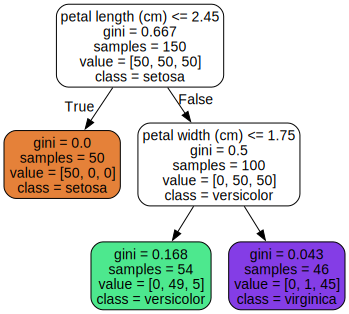

In [8]:
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot")  # path differs in the book

# Making Predictions

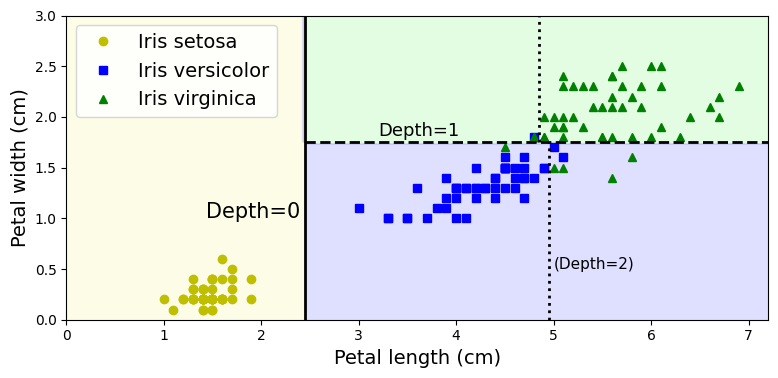

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# extra code – just formatting details
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# extra code – this section beautifies and saves Figure 6–2
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_decision_boundaries_plot")

plt.show()

You can access the tree structure via the `tree_` attribute:

In [10]:
tree_clf.tree_

# Estimating Class Probabilities

In [11]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [12]:
tree_clf.predict([[5, 1.5]])

array([1])

# Regularization Hyperparameters

In [13]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

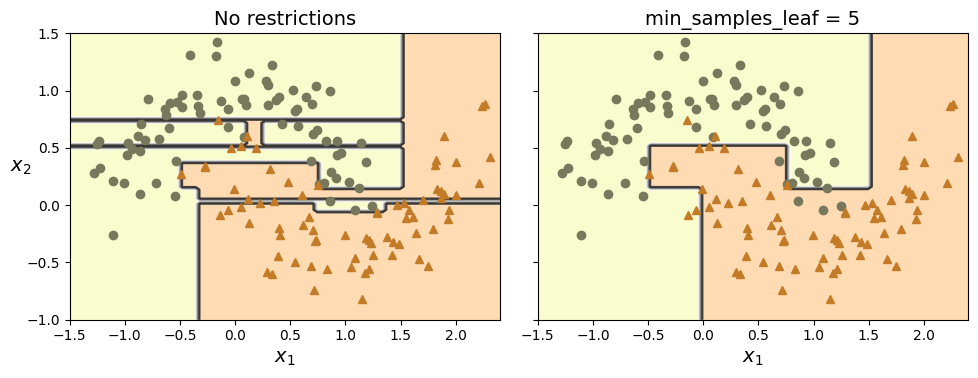

In [14]:
# extra code – this cell generates and saves Figure 6–3

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
save_fig("min_samples_leaf_plot")
plt.show()

In [15]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [16]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92


Tree 1 Score: 0.960
Feature importances: {'petal length': np.float64(0.0), 'petal width': np.float64(1.0)}

Tree 2 Score: 0.960
Feature importances: {'petal length': np.float64(0.0), 'petal width': np.float64(1.0)}

Tree 3 Score: 0.960
Feature importances: {'petal length': np.float64(0.562), 'petal width': np.float64(0.438)}

Tree 4 Score: 0.960
Feature importances: {'petal length': np.float64(0.562), 'petal width': np.float64(0.438)}

Tree 5 Score: 0.960
Feature importances: {'petal length': np.float64(0.562), 'petal width': np.float64(0.438)}

Best performing tree: Tree 1
Score: 0.960


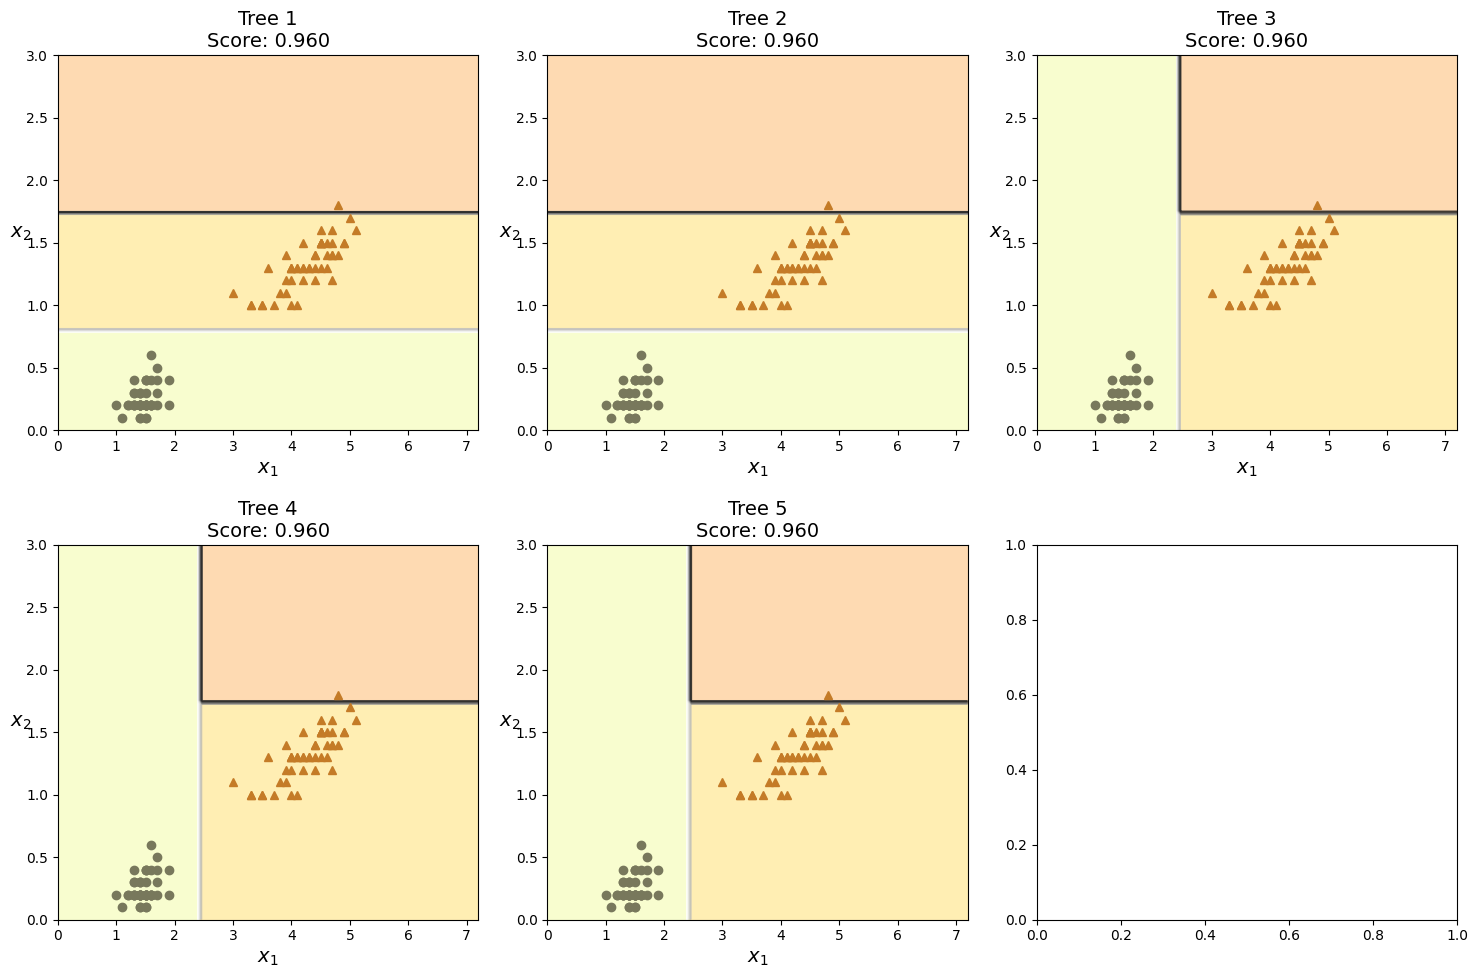

In [17]:
# Decision Tree Stability Analysis
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Load iris dataset
iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

# Train multiple trees and compare
trees = []
scores = []

for i in range(5):  # Build 5 different trees
    tree = DecisionTreeClassifier(max_depth=2, random_state=i)
    tree.fit(X_iris, y_iris)
    score = tree.score(X_iris, y_iris)
    trees.append(tree)
    scores.append(score)
    
    # Visualize each tree
    export_graphviz(
        tree,
        out_file=str(IMAGES_PATH / f"iris_tree_{i}.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )
    
    print(f"\nTree {i+1} Score: {score:.3f}")
    print("Feature importances:", dict(zip(["petal length", "petal width"], 
                                         tree.feature_importances_.round(3))))

# Find best performing tree
best_tree_idx = np.argmax(scores)
print(f"\nBest performing tree: Tree {best_tree_idx + 1}")
print(f"Score: {scores[best_tree_idx]:.3f}")

# Visualize decision boundaries of different trees
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, tree in enumerate(trees):
    if idx < 5:  # Plot first 5 trees
        plt.sca(axes[idx])
        plot_decision_boundary(tree, X_iris, y_iris,
                             axes=[0, 7.2, 0, 3], cmap="Wistia")
        plt.title(f"Tree {idx+1}\nScore: {scores[idx]:.3f}")

plt.tight_layout()
save_fig("tree_stability_comparison")
plt.show()

In [21]:
# Validate tree selection with cross-validation
from sklearn.model_selection import cross_val_score

# Select tree with balanced features 
selected_tree = trees[0]  # 0-based index for Tree 3

# Perform cross-validation
cv_scores = cross_val_score(selected_tree, X_iris, y_iris, cv=5)
print(f"Cross-validation scores: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-validation scores: 0.933 (+/- 0.094)
